# Beginner workflow

This tutorial is a beginner workflow for processing data, visualising the object store and retrieving and visualising data.

### Check installation

This tutorial assumes that you have installed `openghg`. To ensure install has been successful you can open an `ipython` console and import openghg

In a terminal type

```bash
ipython
```

Then import `openghg` and print the version string associated with the version you have installed. If you get something like the below `openghg` is installed correctly.

```ipython
In [1]: import openghg
In [2]: openghg.__version__
Out[2]: '0.0.1'
```

If you get an ``ImportError`` please go back to the install section of the documentation.




### Notebooks

If you haven't used Jupyter notebooks before please see [this introduction](https://realpython.com/jupyter-notebook-introduction/).

## 1. Setting up our environment

First the notebook sets up the environment needed to create the object store at our desired location. By default this location
is at ``/tmp/openghg_store``. For the purposes of this tutorial this path is fine but as it is a temporary directory it may not survive a
reboot of the computer. 

If you want to create an object store that survives a reboot you can change the path to anything you like. We
recommened a path such as ``~/openghg_store`` which will create the object store in your home directory in a directory called ``openghg_store``.

In [1]:
from openghg.store import ObsSurface
from openghg.objectstore import visualise_store
from openghg.localclient import get_obs_surface, RankSources
from openghg.retrieve import search
from openghg.util import bilsdale_datapaths

import glob
from pathlib import Path

import os
import tempfile

### Set an environment variable for the OpenGHG object store

Here we create a temporary directory but you can use any folder you like by setting a path in place of `tmp_dir.name`. The object store created by this notebook will only have a lifetime as long as the notebook, if you want to create a longer lived object store set a path below.

In [2]:
tmp_dir = tempfile.TemporaryDirectory()
os.environ["OPENGHG_PATH"] = tmp_dir.name # "/tmp/openghg_store"


## 2. Processing data

First we want to process some files from our local directory

In [3]:
bsd_datapaths = bilsdale_datapaths()

We can pass this filepath to `ObsSurface.read_file`. We must also tell it the type of data we want it to process, DECC data is CRDS. We also pass in the site code and the name of the network.

In [4]:
decc_results = ObsSurface.read_file(filepath=bsd_datapaths, data_type="CRDS", site="bsd", network="DECC")

Processing: bsd.picarro.1minute.108m.min.dat: 100%|████████████████████| 3/3 [00:00<00:00, 13.98it/s]


Here `decc_results` will give us a dictionary with the UUIDs (universally unique identifiers) for each of the Datasources the data has been assigned to. This tells us that the data has been processed and stored correctly.

## A note on Datasources

Datasources are objects that are stored in the object store (add link to object store notes) that hold the data and metadata associated with each measurement we upload to the platform.

For example, if we upload a file that contains readings for three gas species from a single site at a specific inlet height OpenGHG    will assign this data to three different Datasources, one for each species. Metadata such as the site, inlet height, species, network etc are stored alongside the measurements for easy searching. 

Datasources can also handle multiple versions of data from a single site, so if scales or other factors change multiple versions may be stored for easy future comparison.

#### Note

When you run this notebook different UUIDs will be created for the Datasources. This is expected as 
each time a Datasource is created from scratch it is assigned a unique UUID.


In [5]:
decc_results

defaultdict(dict,
            {'processed': {'bsd.picarro.1minute.248m.min.dat': {'ch4': '360d6b35-18e6-4c1c-849b-b797b94200d1',
               'co2': '008bd26b-2c62-4f61-b8ec-3db7159afc1e',
               'co': '44d91408-698d-4756-b953-ab5e1d115d90'},
              'bsd.picarro.1minute.42m.min.dat': {'ch4': '6f8c6e7b-c986-4ead-b97a-03ca80288206',
               'co2': '470541fe-f806-4848-b555-0a3f9b690d44',
               'co': '3fe2f08b-68db-425f-ac7d-8bc5b6eb9537'},
              'bsd.picarro.1minute.108m.min.dat': {'ch4': '19a14b2d-1bd7-4f3a-9c1e-47c02b70aafd',
               'co2': '05220a43-cd63-49ee-8101-3e37176d0556',
               'co': '51caeacd-e4d9-4f0f-8a0a-d0622a2831d4'}}})

We can now process the AGAGE data. The functions that process the AGAGE data expect data to have an accompanying precisions file. For each data file we create a tuple with the data filename and the precisions filename. A simpler method of uploading these file types is planned.

We must create a `tuple` for each pair

```python
list_of_tuples = [(data_filepath, precision_filepath), (d1, p1), (d2, p2), ...]
```

In [6]:
agage_tuples = [('../data/AGAGE/capegrim-medusa.18.C', '../data/AGAGE/capegrim-medusa.18.precisions.C')]

Then we process the files as we did before the with DECC data, but this time changing the data type to the `GCWERKS` type and the network to `AGAGE`.

In [7]:
agage_results = ObsSurface.read_file(filepath=agage_tuples, data_type="GCWERKS", site="CGO", network="AGAGE")

Processing: capegrim-medusa.18.C:   0%|                                        | 0/1 [00:00<?, ?it/s]

/Users/gar/Documents/Devel/openghg/openghg/standardise/surface/_gcwerks.py:288: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gas_name + " integration_flag"] = (data[column].str[1] != "-").astype(int)
/Users/gar/Documents/Devel/openghg/openghg/standardise/surface/_gcwerks.py:287: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[gas_name + " status_flag"] = (data[column].str[0] != "-").astype(int)


Processing: capegrim-medusa.18.C: 100%|████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


When viewing `agage_results` there will be a large number of Datasource UUIDs shown due to the large number of gases in each data file

In [8]:
agage_results

defaultdict(dict,
            {'processed': {'capegrim-medusa.18.C': {'nf3_70m': '2008413a-3004-4692-b936-5629f971f11f',
               'cf4_70m': '9a14baa9-0529-465a-a2fd-3da390356955',
               'pfc116_70m': '0ef46a23-3b56-44a7-9530-92fd21d29fef',
               'pfc218_70m': '81db7c94-92c9-4261-b2e2-c658f7a91b9b',
               'pfc318_70m': '99d29de7-7e87-49a0-9c30-ec86ec238024',
               'c4f10_70m': '77e7aeda-92d7-40b3-ab20-b200da41861d',
               'c6f14_70m': 'bbc0c6b0-9295-42d6-9ce1-a28807ef49c2',
               'sf6_70m': '8dbe726b-380e-4737-9eb6-292eeac3f14b',
               'so2f2_70m': '806b23cb-5087-4455-aa93-00e5322cc44e',
               'sf5cf3_70m': 'fd3884c2-3288-4a88-8e96-9d3823e3bf13',
               'hfc23_70m': '1557c52c-bbd7-44cc-b81b-7be12b249d1a',
               'hfc32_70m': 'b48bd959-ca37-4bf4-a094-6486749c37ef',
               'hfc125_70m': '147e6a9f-0231-4d46-869e-d4e04ecd39d5',
               'hfc134a_70m': '0f193be7-403a-4c55-b09b-86df6f3

## 3. Visualising the object store

Now that we have a simple object store created we can view the objects within it in a simple force graph model. To do this we use the `view_store` function from the `objectstore` submodule. Note that the cell may take a few moments to load as the force graph is created.

In the force graph the central blue node is the `ObsSurface` node. Associated with this node are all the data processed by it. The next node in the topology are networks, shown in green. In the graph you will see `DECC` and `AGAGE` nodes. From these you'll see site nodes in red and then individual datasources in orange.

#### Note

The object store visualisation created by this function is commented out here and won't be visible in the documentation but can be uncommented and run when you use the notebook version.


In [9]:
visualise_store()

Now we know we have this data in the object store we can search it and retrieve data from it.

## 4. Retrieving data 

To retrieve data from the object store we can use the `get_obs_surface` function from the `localclient` submodule. This allows us to retrieve and view the data stored.

In [10]:
data = get_obs_surface(site="bsd", species="co", network="AGAGE", inlet="248m")

If we view data we expect an `ObsData` object to have been returned

In [11]:
data

ObsData(data=<xarray.Dataset>
Dimensions:                    (time: 142)
Coordinates:
  * time                       (time) datetime64[ns] 2014-01-30T11:12:30 ... ...
Data variables:
    mf                         (time) float64 202.4 203.2 205.1 ... 114.5 114.2
    mf_variability             (time) float64 5.265 6.307 8.518 ... 7.339 5.405
    mf_number_of_observations  (time) float64 26.0 26.0 25.0 ... 23.0 24.0 23.0
Attributes: (12/23)
    data_owner:           Simon O'Doherty
    data_owner_email:     s.odoherty@bristol.ac.uk
    inlet_height_magl:    248m
    comment:              Cavity ring-down measurements. Output from GCWerks
    long_name:            bilsdale
    Conditions of use:    Ensure that you contact the data owner at the outse...
    ...                   ...
    sampling_period:      60
    inlet:                248m
    port:                 9
    type:                 air
    network:              decc
    scale:                WMO-X2014A, metadata={'site': 'bsd'

First we tell `matplotlib` that we are plotting inside a Jupyter notebook, this ensures a plot with controls is created.

In [12]:
%matplotlib notebook

<IPython.core.display.Javascript object>


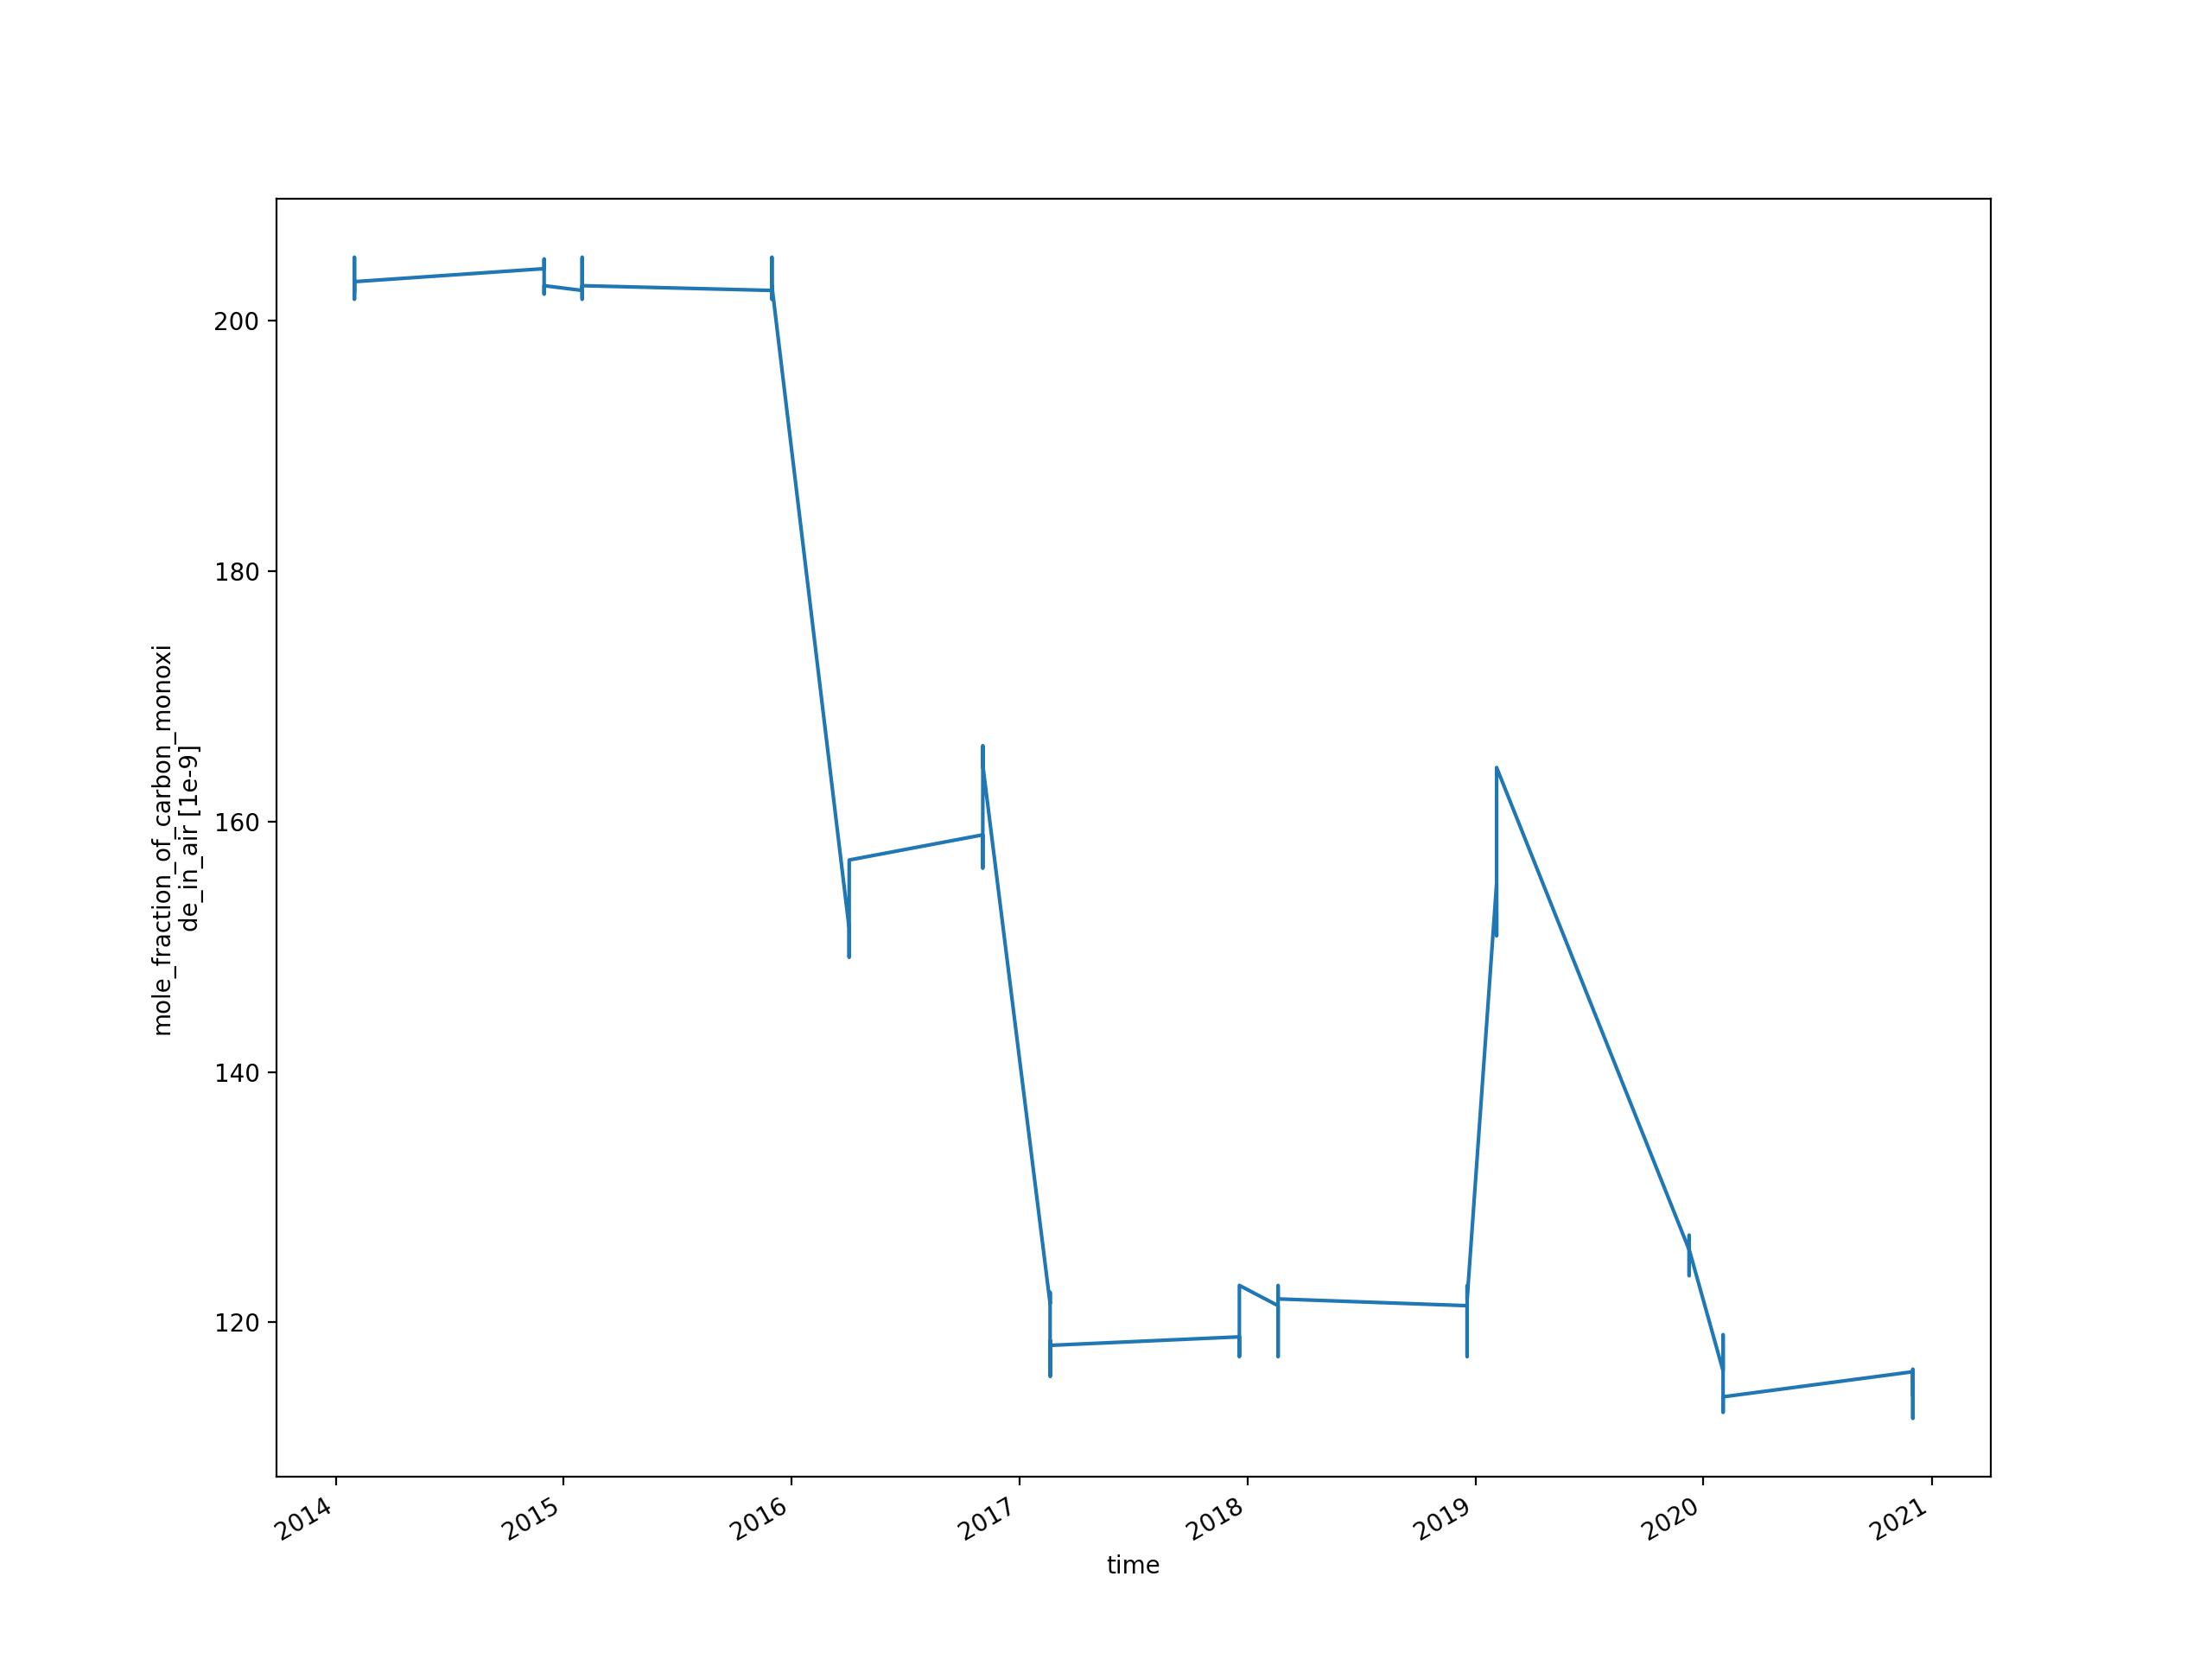

In [13]:
example_data = data.data
mol_frac = example_data.mf
mol_frac.plot()

## 5. Ranking data

The dates that the data from Heathfield retrieved above overlap. If we want to easily retrieve the highest quality data from Heathfield over a range of dates we don't want to have to repeatedly check which was the correct inlet/instrument for a given daterange. This problem is solved using ranking. 

A given inlet on a specific instrument at a site can be given a rank for a daterange. To do this we use the `RankSources` class from the `localclient` submodule.

## Get ranking data

In [14]:
r = RankSources()
r.get_sources(site="bsd", species="co")

{'co_248m_picarro': {'rank_data': 'NA',
  'data_range': '2014-01-30T11:12:30_2020-12-01T22:31:30'},
 'co_42m_picarro': {'rank_data': 'NA',
  'data_range': '2014-01-30T11:12:30_2020-12-01T22:31:30'},
 'co_108m_picarro': {'rank_data': 'NA',
  'data_range': '2014-01-30T11:12:30_2020-12-01T22:31:30'}}

## Set ranking data

This tells us that there is no rank set for CO data at Bisldale. Say we want to prioritise data from different inlet heights between certain dates we can set the ranks like so

In [15]:
r.set_rank(key="co_248m_picarro", rank=1, start_date="2016-01-01", end_date="2018-01-01")
r.set_rank(key="co_42m_picarro", rank=1, start_date="2018-01-02", end_date="2019-05-30")
r.set_rank(key="co_108m_picarro", rank=1, start_date="2019-05-30", end_date="2021-11-30")

Now we can check everything was set correctlying using `get_sources` again as above

In [16]:
r.get_sources(site="bsd", species="co")

{'co_248m_picarro': {'rank_data': {'2016-01-01-00:00:00+00:00_2018-01-01-00:00:00+00:00': 1},
  'data_range': '2014-01-30T11:12:30_2020-12-01T22:31:30'},
 'co_42m_picarro': {'rank_data': {'2018-01-02-00:00:00+00:00_2019-05-30-00:00:00+00:00': 1},
  'data_range': '2014-01-30T11:12:30_2020-12-01T22:31:30'},
 'co_108m_picarro': {'rank_data': {'2019-05-30-00:00:00+00:00_2021-11-30-00:00:00+00:00': 1},
  'data_range': '2014-01-30T11:12:30_2020-12-01T22:31:30'}}

## Retrieve ranked data

We can now retrive CO data from Bilsdale and we'll get the data from the highest ranked inlets.

In [17]:
co_data = get_obs_surface(site="bsd", species="co")

This retrieves the data and creates an `ObsData` dataclass. This holds the data in an xarray `Dataset`, the metadata associated with the site and each inlet and the ranking metadata. 

Let's have a look at the rank metadata

In [18]:
co_data.metadata["rank_metadata"]

{'2016-01-01-00:00:00+00:00_2018-01-01-00:00:00+00:00': '248m',
 '2018-01-02-00:00:00+00:00_2019-05-30-00:00:00+00:00': '42m',
 '2019-05-30-00:00:00+00:00_2021-11-30-00:00:00+00:00': '108m'}

In [19]:
co_data.data

<xarray.Dataset>
Dimensions:                    (time: 162)
Coordinates:
  * time                       (time) datetime64[ns] 2014-01-30T11:12:30 ... ...
Data variables:
    mf                         (time) float64 202.4 203.2 205.1 ... 114.5 114.2
    mf_variability             (time) float64 5.265 6.307 8.518 ... 7.339 5.405
    mf_number_of_observations  (time) float64 26.0 26.0 25.0 ... 23.0 24.0 23.0
Attributes: (12/23)
    data_owner:           Simon O'Doherty
    data_owner_email:     s.odoherty@bristol.ac.uk
    inlet_height_magl:    108m
    comment:              Cavity ring-down measurements. Output from GCWerks
    long_name:            bilsdale
    Conditions of use:    Ensure that you contact the data owner at the outse...
    ...                   ...
    sampling_period:      60
    inlet:                108m
    port:                 9
    type:                 air
    network:              decc
    scale:                WMO-X2014A

In [20]:
co_data.metadata

{'248m': {'site': 'bsd',
  'instrument': 'picarro',
  'sampling_period': '60',
  'inlet': '248m',
  'port': '9',
  'type': 'air',
  'network': 'decc',
  'species': 'co',
  'scale': 'wmo-x2014a',
  'long_name': 'bilsdale',
  'data_type': 'timeseries'},
 '42m': {'site': 'bsd',
  'instrument': 'picarro',
  'sampling_period': '60',
  'inlet': '42m',
  'port': '9',
  'type': 'air',
  'network': 'decc',
  'species': 'co',
  'scale': 'wmo-x2014a',
  'long_name': 'bilsdale',
  'data_type': 'timeseries'},
 '108m': {'site': 'bsd',
  'instrument': 'picarro',
  'sampling_period': '60',
  'inlet': '108m',
  'port': '9',
  'type': 'air',
  'network': 'decc',
  'species': 'co',
  'scale': 'wmo-x2014a',
  'long_name': 'bilsdale',
  'data_type': 'timeseries'},
 'rank_metadata': {'2016-01-01-00:00:00+00:00_2018-01-01-00:00:00+00:00': '248m',
  '2018-01-02-00:00:00+00:00_2019-05-30-00:00:00+00:00': '42m',
  '2019-05-30-00:00:00+00:00_2021-11-30-00:00:00+00:00': '108m'},
 'data_owner': "Simon O'Doherty",


Now we have the highest ranked data for Bilsdale.

## 7. Cleanup

If you used the `tmp_dir` as a location for your object store at the start of the tutorial you can run the cell below to remove any files that were created.

In [21]:
tmp_dir.cleanup()

## 8. What's next?

Further tutorials will be added soon. If you want to explore the internal workings of OpenGHG please checkout the Developer API documentation, if you would like contribute to the project we welcome pull requests to both the code and the documentation. For help and guidance on contributing check our contributing page.